
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


KNN | acc=0.392  f1_macro=0.215
Tree | acc=0.414 f1_macro=0.216
LDA | acc=0.458  f1_macro=0.185


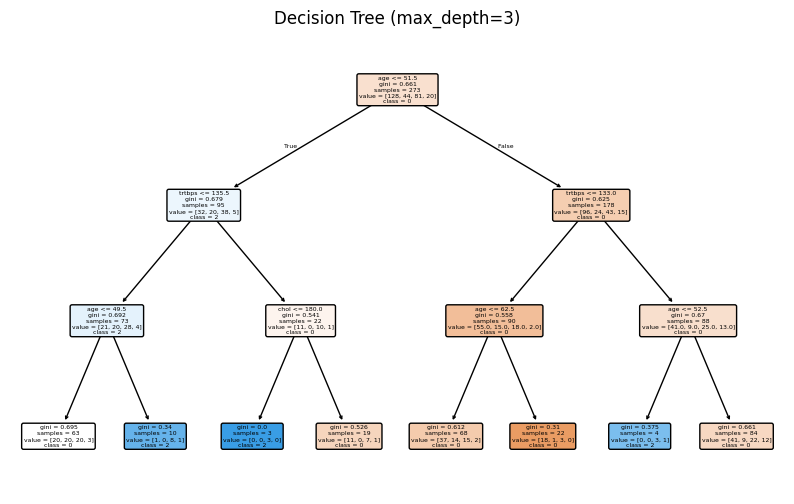

In [3]:
X = ha[["trtbps", "chol", "age"]].copy()
y = ha["cp"].astype(str)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KNN
knn_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
knn_acc = cross_val_score(knn_pipe, X, y, cv=cv, scoring="accuracy").mean()
knn_f1m = cross_val_score(knn_pipe, X, y, cv=cv, scoring="f1_macro").mean()
knn_pipe.fit(X, y)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_acc = cross_val_score(tree, X, y, cv=cv, scoring="accuracy").mean()
tree_f1m = cross_val_score(tree, X, y, cv=cv, scoring="f1_macro").mean()
tree.fit(X, y)

# LDA
lda_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])
lda_acc = cross_val_score(lda_pipe, X, y, cv=cv, scoring="accuracy").mean()
lda_f1m = cross_val_score(lda_pipe, X, y, cv=cv, scoring="f1_macro").mean()
lda_pipe.fit(X, y)

print(f"KNN | acc={knn_acc:.3f}  f1_macro={knn_f1m:.3f}")
print(f"Tree | acc={tree_acc:.3f} f1_macro={tree_f1m:.3f}")
print(f"LDA | acc={lda_acc:.3f}  f1_macro={lda_f1m:.3f}")

plt.figure(figsize=(10,6))
plot_tree(tree, feature_names=["trtbps","chol","age"], class_names=sorted(y.unique()), filled=True, rounded=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [4]:
from sklearn.linear_model import LogisticRegression

for c in [0,1,2,3]:
    ha[f"cp_is_{c}"] = (ha["cp"] == c).astype(int)

X = ha[["trtbps", "chol", "age"]].copy()

def ovr_f1(c):
    y_bin = ha[f"cp_is_{c}"]
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("logit", LogisticRegression(max_iter=2000, solver="liblinear"))
    ])
    f1 = cross_val_score(pipe, X, y_bin, cv=5, scoring="f1").mean()
    return f1

ovr_scores = {c: ovr_f1(c) for c in [0,1,2,3]}
print("OvR F1 by class:", {k: round(v,3) for k,v in ovr_scores.items()})
best_class = max(ovr_scores, key=ovr_scores.get)
print(f"OvR best-distinguished class (by F1): cp={best_class}")

OvR F1 by class: {0: np.float64(0.461), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.0)}
OvR best-distinguished class (by F1): cp=0


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [5]:
def ovo_auc(pair):
    a, b = pair
    sub = ha[ha["cp"].isin([a,b])].copy()
    Xp  = sub[["trtbps","chol","age"]]
    pos = max(a,b)
    yp  = (sub["cp"] == pos).astype(int)
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("logit", LogisticRegression(max_iter=2000, solver="liblinear"))
    ])
    auc = cross_val_score(pipe, Xp, yp, cv=5, scoring="roc_auc").mean()
    return auc

pairs = [(0,1), (0,2), (0,3)]
auc_by_pair = {p: ovo_auc(p) for p in pairs}
print("OvO ROC-AUC:", {str(k): round(v,3) for k,v in auc_by_pair.items()})
best_pair = max(auc_by_pair, key=auc_by_pair.get)
print(f"OvO best-separated pair (by ROC-AUC): {best_pair}")

OvO ROC-AUC: {'(0, 1)': np.float64(0.603), '(0, 2)': np.float64(0.559), '(0, 3)': np.float64(0.562)}
OvO best-separated pair (by ROC-AUC): (0, 1)


OvO evaluates separability between two classes across all thresholds. ROC-AUC summarizes that trade-off threshold-free

OvO probabilities do not sum to 1. Each pairwise model outputs a probability for b vs a. These are pair specific and not jointly calibrated to sum to 1 across all classes

There are 6 pairs OvO regressions for 4 classes

Use pairwise voting (each model casts a vote, class with most wins) or aggregate calibrated probabilities and choose argmax

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!wget -q https://quarto.org/download/latest/quarto-linux-amd64.deb
!sudo dpkg -i quarto-linux-amd64.deb || true
!sudo apt-get -y -f install
!sudo dpkg -i quarto-linux-amd64.deb
!quarto check

Selecting previously unselected package quarto.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack quarto-linux-amd64.deb ...
Unpacking quarto (1.8.26) ...
Setting up quarto (1.8.26) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
(Reading database ... 124564 files and directories currently installed.)
Preparing to unpack quarto-linux-amd64.deb ...
Unpacking quarto (1.8.26) over (1.8.26) ...
Setting up quarto (1.8.26) ...
Quarto 1.8.26
[✓] Checking environment information...
      Quarto cache location: /root/.cache/quarto
[✓] Checking versions of quarto binary dependencies...
      Pandoc version 3.6.3: OK
      Dart Sass version 1.87.0: OK
      Deno version 2.3.1: OK
      Typst version 0.13.0: OK
[✓] Checking versions of quarto dependencies......OK
[✓] Checking Quarto installation......OK
      Version: 1.8.26
      Path: /op

In [8]:
!quarto render "/content/drive/My Drive/Colab Notebooks/PA 9.2.ipynb" --to html

pandoc 
  to: html
  output-file: PA 9.2.html
  standalone: true
  section-divs: true
  html-math-method: mathjax
  wrap: none
  default-image-extension: png
  variables: {}
  
metadata
  document-css: false
  link-citations: true
  date-format: long
  lang: en
  
Output created: PA 9.2.html

